#Data Retrieval

In [ ]:
fresno_pm25_df = get_county_pm25_data(fresno_code)

Added data for 1999
Added data for 2000


KeyboardInterrupt: 

# Step 2: Handle Missing Values: make sure that the daily data have consistent daily intervals.

In [ ]:
# Retrieve the AQI value for each unique combination of Date and Monitor location
fresno_pm25_univariate_df = fresno_pm25_df.groupby(['date_local', 'site_number'])['aqi'].mean().reset_index()

In [ ]:
fresno_pm25_univariate_df

,date_local,site_number,aqi
0,1999-01-03,0008,119.0
1,1999-01-03,5001,98.0
2,1999-01-06,0008,115.0
3,1999-01-06,5001,91.0
4,1999-01-09,0008,159.0
...,...,...,...
29422,2025-03-27,0500,23.0
29423,2025-03-28,0500,16.0
29424,2025-03-29,0500,13.0
29425,2025-03-30,0500,17.0


In [ ]:
# Get the average AQI value of all monitors for each day
fresno_pm25_daily_df = fresno_pm25_univariate_df.groupby("date_local")['aqi'].mean().reset_index()

In [ ]:
fresno_pm25_daily_df

,date_local,aqi
0,1999-01-03,108.5
1,1999-01-06,103.0
2,1999-01-09,159.0
3,1999-01-12,165.0
4,1999-01-15,203.0
...,...,...
9196,2025-03-27,23.0
9197,2025-03-28,16.0
9198,2025-03-29,13.0
9199,2025-03-30,17.0


In [ ]:
daily_index = pd.date_range(start="1999-01-01", end="2025-03-31", freq="D")

In [ ]:
# Set the date to datetime type
fresno_pm25_daily_df["date_local"] = pd.to_datetime(fresno_pm25_daily_df["date_local"])

In [ ]:
# set the date_local column to index
fresno_pm25_univariate_df = fresno_pm25_daily_df.set_index("date_local")

# add missing days so that all consecutive days are included
fresno_pm25_univariate_df = fresno_pm25_univariate_df.reindex(daily_index)

In [ ]:
fresno_pm25_univariate_df

,aqi
1999-01-01,NaN
1999-01-02,NaN
1999-01-03,108.5
1999-01-04,NaN
1999-01-05,NaN
...,...
2025-03-27,23.0
2025-03-28,16.0
2025-03-29,13.0
2025-03-30,17.0


In [ ]:
# Fill in the missing values based on nearby days' values; interpolate based on actual time gaps
fresno_pm25_univariate_df["aqi"] = fresno_pm25_univariate_df["aqi"].interpolate(method="time")

In [ ]:
# Fill start and end values
fresno_pm25_univariate_df['aqi'] = fresno_pm25_univariate_df['aqi'].ffill().bfill()

# Step 3: Detect and Smooth Outliers (interested in typical daily PM 2.5 AQI predictions instead of focusing on rare events)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

Visualize Before Outlier Smoothing

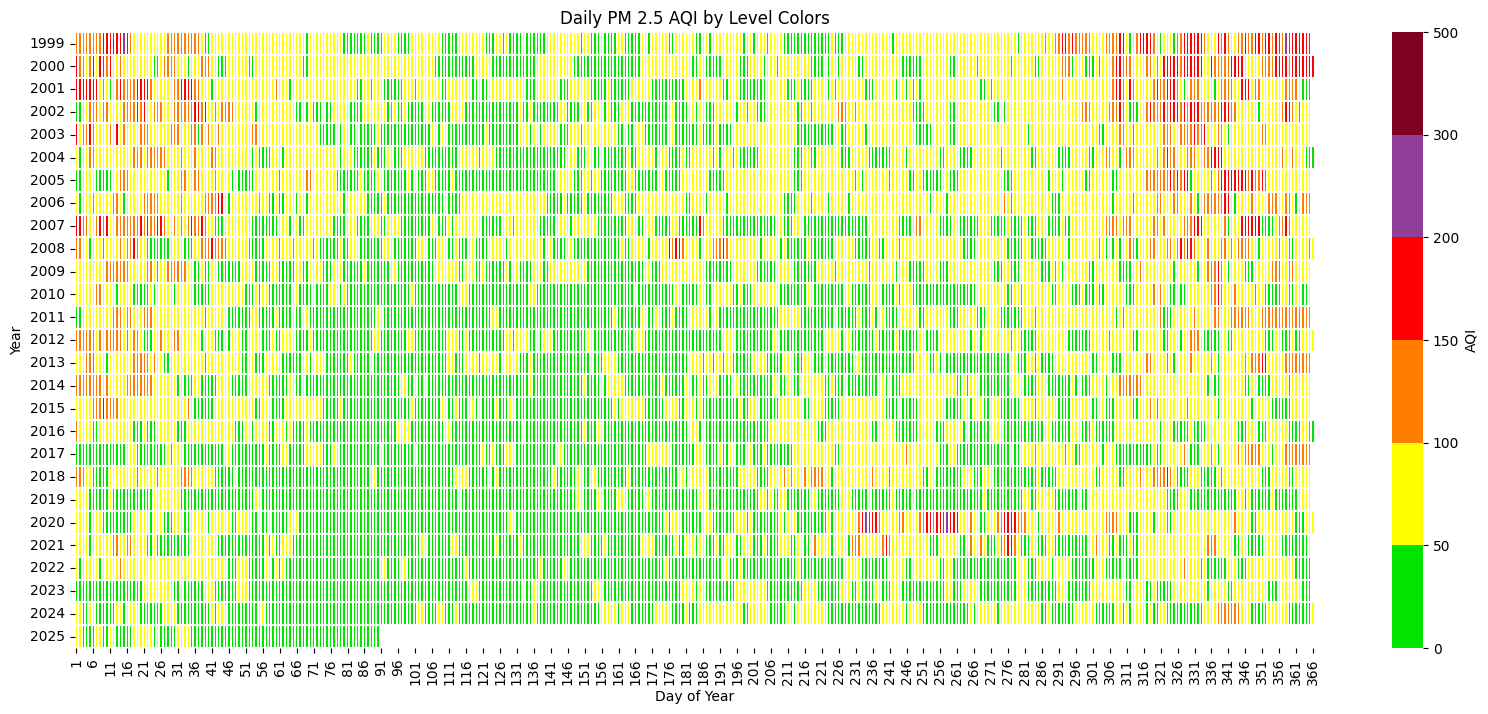

In [ ]:
fresno_pm25_univariate_df['date_local'] = pd.to_datetime(fresno_pm25_univariate_df.index)
fresno_pm25_univariate_df['year'] = fresno_pm25_univariate_df['date_local'].dt.year
fresno_pm25_univariate_df['dayofyear'] = fresno_pm25_univariate_df['date_local'].dt.dayofyear

# Pivot to Year x DayOfYear matrix
pivot_df = fresno_pm25_univariate_df.pivot(index='year', columns='dayofyear', values='aqi')
# Define EPA PM2.5 AQI colors
aqi_colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']

# Define AQI breakpoints
bounds = [0, 50, 100, 150, 200, 300, 500]

# Create custom colormap and norm
cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar_kws={'label': 'AQI'}, linewidths=0.05)

# Customize plot
plt.title('Daily PM 2.5 AQI by Level Colors')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

#Apply Outlier Detection and Smoothing

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
# Reshape AQI values to 2D array
X = fresno_pm25_univariate_df['aqi'].values.reshape(-1, 1)

# Initialize model with the optimal contamination level
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model
model.fit(X)

# Predict anomalies (-1 for outliers, 1 for inliers)
fresno_pm25_univariate_df['outlier_flag'] = model.predict(X)

In [ ]:
def get_previous_year_aqi(x):
    match = fresno_pm25_univariate_df.loc[
        (fresno_pm25_univariate_df.index.month == x.month) &
        (fresno_pm25_univariate_df.index.day == x.day) &
        (fresno_pm25_univariate_df.index.year == x.year - 1), 'aqi']

    # If there's at least one match, take the mean (or first value)
    if not match.empty:
        return match.mean()  # or match.iloc[0]
    else:
        return np.nan

fresno_pm25_univariate_df['previous_year_aqi'] = fresno_pm25_univariate_df.index.map(get_previous_year_aqi)

In [ ]:
# Replace outliers with previous year AQI values
fresno_pm25_univariate_df['aqi_cleaned'] = fresno_pm25_univariate_df['aqi']
fresno_pm25_univariate_df.loc[fresno_pm25_univariate_df['outlier_flag'] == -1, 'aqi_cleaned'] = fresno_pm25_univariate_df['previous_year_aqi']

# Fill remaining NaNs (where no previous year data exists)
fresno_pm25_univariate_df['aqi_cleaned'].fillna(fresno_pm25_univariate_df['aqi'].median(), inplace=True)

<ipython-input-21-3b25adc1226b>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fresno_pm25_univariate_df['aqi_cleaned'].fillna(fresno_pm25_univariate_df['aqi'].median(), inplace=True)


#Visualize After Outlier Detection and Smoothing

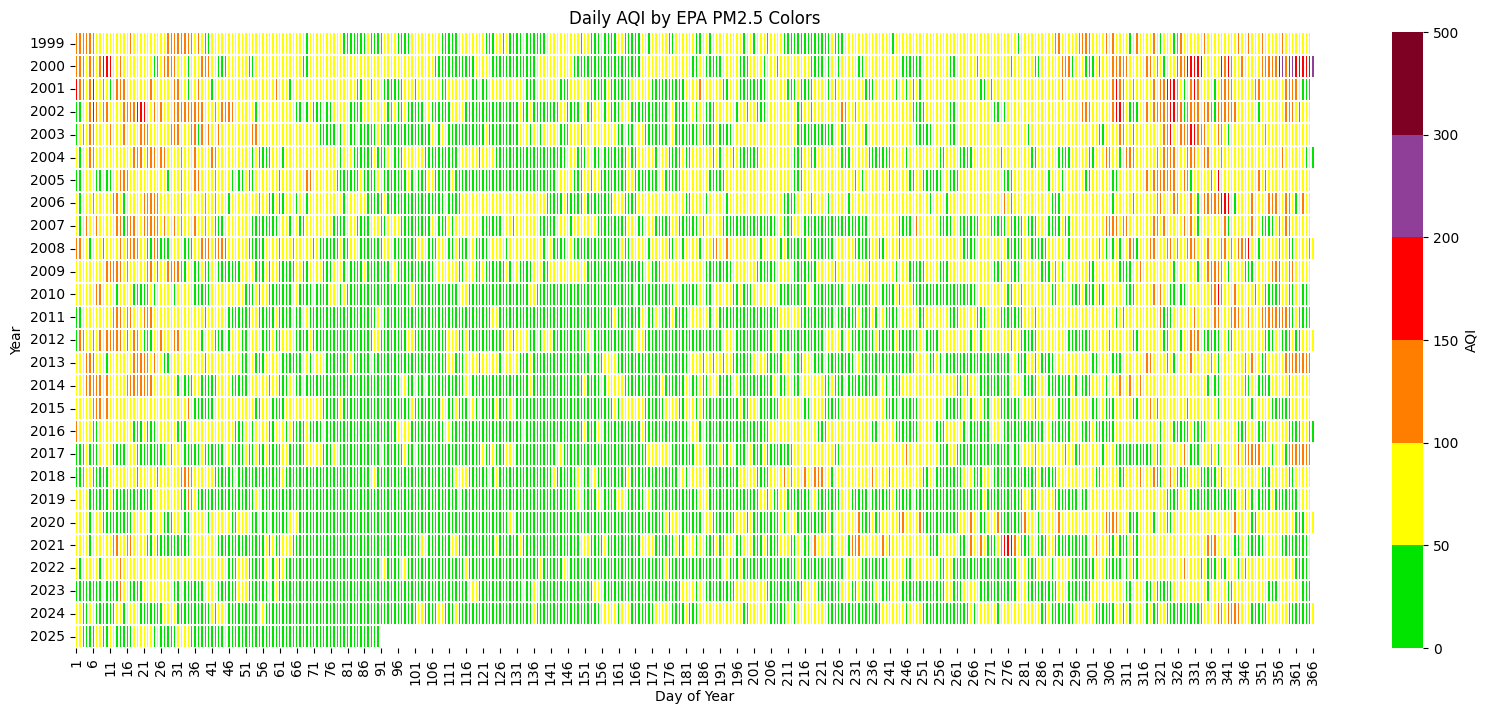

In [ ]:
pivot_df = fresno_pm25_univariate_df.pivot(index='year', columns='dayofyear', values='aqi_cleaned')
# Define EPA PM2.5 AQI colors
aqi_colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']

# Define AQI breakpoints
bounds = [0, 50, 100, 150, 200, 300, 500]

# Create custom colormap and norm
cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar_kws={'label': 'AQI'}, linewidths=0.05)

# Customize plot
plt.title('Daily AQI by EPA PM2.5 Colors')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()